## Computation of confidence intervals using a grid search
Computing confidence intervals using a grid search is a method particularly useful when analytic solutions are unavailable. By evaluating the parameter space, calculating posterior probabilities for every point, and deriving credible intervals we get a confidence interval given the data and prior knowledge such that P[Θ ∈ I | X] = 1−α where alpha is our confidence level. In this manner  it is an analogue to a frequentist confidence interval.

By first creating a fine grid of plausible values for our parameters and defining a posterior, following bayesian inference, we can compute the value of the posterior in each point. Meaning that every combination of n parameters is used to calculate the posterior giving a hypercube filled with **m_1 \cdot m_2 \cdot ... \cdot m_n** points. (for ** m_i** the total number of chosen grid values).
 

To identify the confidence interval we have two main methods. For symmetric distributions we look at an equal tail approximation. The interval [θ(α/2),θ(1−α/2)] determines the region where all points lay such the probability for a point to lay in this interval is 1- alpha. This reflects the true probability the value of our parameter lies in that interval. However this brings some ambiguity into play. Imagine a simple gaussian distribution. we can construct a alpa =0.5 interval on the left side going from -inf to the mean or an interval on the right side. we can also have the mean in the middle of the interval and symmetrically go to both side. To solve this ambivalence we try to minimize the length of the interval. Or let the interval be determined by equalling the excluded area on both tail-ends. rtest



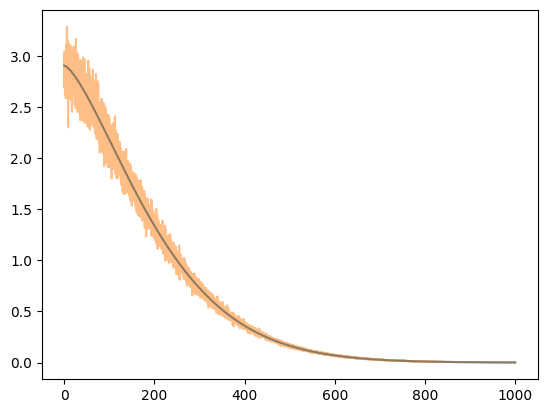

In [302]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import numpy as np
import scipy.optimize as opt
import scipy.special as sp

import matplotlib.pyplot as plt

# -------------------- Step 1: Simulate Gravitational Wave Data --------------------
np.random.seed(120847)
def sersic_profile(r, r_e, n):
    """Compute the Sérsic profile"""
    b_n = 2 * n - 1/3  # Approximation for b_n for n > 0.5
    return np.exp(-b_n * ((r / r_e)**(1/n) - 1))
   
def sim_data(r,r_e,n, fractional_uncertainty):
	y_true = sersic_profile(r,r_e,n)
	y_unc_true = np.abs(y_true)*fractional_uncertainty
	y_sample = np.random.normal(y_true, y_unc_true, size=len(r))
	return y_sample, y_unc_true


R_max  = 1e3 
r_range = np.linspace(0,R_max,10000)


# True parameters
true_n = 0.7
true_r_e = 250

#simulating data
fractional_uncertainty = 0.05
sim_r, sim_r_uncertainty = sim_data(r_range, true_r_e, true_n, fractional_uncertainty)

plt.figure()
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n))
plt.plot(r_range, sim_r, alpha=0.5)
plt.show()

In [315]:
# -------------------- Step 2: Define Prior and Likelihood --------------------

def flat_prior(r_e,n ):
    """
    Flat prior: Assuming parameters are bounded in some range [min, max].
    """
    if 0.5<= n <= 2 and 249 <= r_e <= 251:  # Example bounds
        return 1
    return 0

def log_likelihood(r, observed, sigma, r_e, n,):
    model_density = sersic_profile(r, r_e, n)
    # Compute log-likelihood assuming Gaussian errors
    log_likelihood_value = -np.sum(0.5 * ((observed - model_density) / sigma) ** 2 + np.log(sigma * np.sqrt(2 * np.pi)))
    return  log_likelihood_value


In [316]:
# Create a 2D grid of r_e and n

r_e_space = np.linspace(240, 260, 400)
n_space = np.linspace(0.65, 0.75, 400)
posterior_grid = np.zeros((len(r_e_space),len(n_space)))

# Loop over all combinations of n and r_e, filling in the grid with values of the posterior
for i in tqdm(range(len(n_space))):
    for j in range(len(r_e_space)):
        prior = flat_prior(r_e_space[j], n_space[i] )
        # Compute likelihood for this position (using the simulated data)
        likelihood_value = log_likelihood(r_range, sim_r, sim_r_uncertainty,r_e_space[j], n_space[i] )
        # Compute the posterior for this position (product of likelihood and prior)
        posterior_grid[i, j] = likelihood_value * prior


posterior_grid /= np.sum(posterior_grid)  # Normalize
posterior_grid_old = posterior_grid # for later


#  best-fit parameters
max_idx = np.unravel_index(np.argmax(posterior_grid), posterior_grid.shape)
best_fit_n = n_space[max_idx[0]]
best_fit_r_e = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n}")
print(f"Best-fit r_e: {best_fit_r_e}")  

100%|██████████| 400/400 [00:42<00:00,  9.35it/s]

Best-fit n: 0.6996240601503759
Best-fit r_e: 250.0751879699248


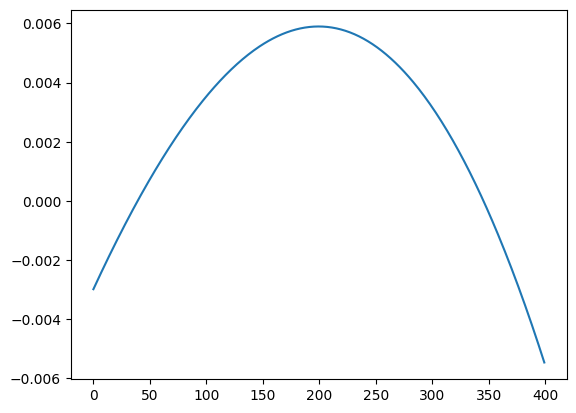

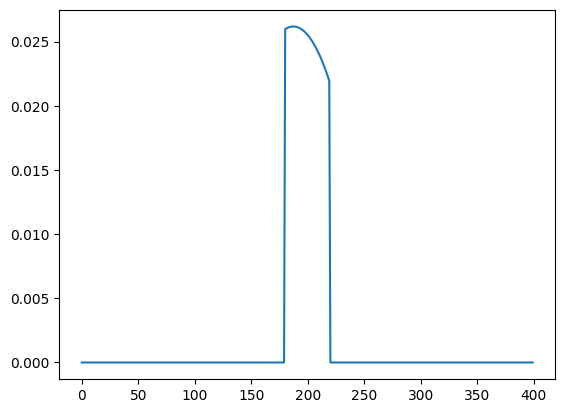

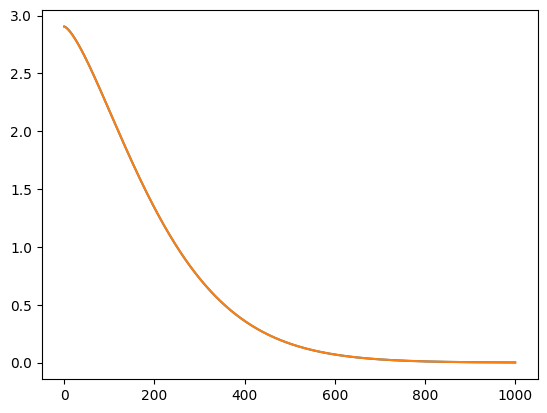

In [317]:
plt.figure()
plt.plot(np.sum(posterior_grid_old, axis=1))

plt.figure()
plt.plot(np.sum(posterior_grid_old, axis=0))


plt.figure()
plt.plot(r_range, sersic_profile(r_range, true_r_e,true_n))
plt.plot(r_range, sersic_profile(r_range, best_fit_r_e,best_fit_n))
plt.show()


In [306]:
def compute_equal_tailed_interval(parameter_space, posterior, alpha=0.05):
    cdf = np.cumsum(posterior)
    lower_bound = parameter_space[np.searchsorted(cdf, alpha / 2)]
    upper_bound = parameter_space[np.searchsorted(cdf, 1 - alpha / 2)]
    return lower_bound, upper_bound

def find_minimal_interval(parameter_space, posterior, alpha):
    # Normalize posterior to ensure it sums to 1
    posterior = posterior / np.sum(posterior)

    # Initialize variables
    min_width = np.inf
    best_interval = None
    target_prob =  1-alpha
    
    # Sliding window
    for i in range(len(parameter_space)):  # Start of the window
        cumulative_prob = 0  # Reset cumulative probability for each new starting point
        
        for j in range(i, len(parameter_space)):  # End of the window
            # Expand the window by adding the probability at j
            cumulative_prob += posterior[j]

            # Check if the window meets or exceeds the target probability
            if cumulative_prob >= target_prob:
                # Calculate the width of the current window
                width = parameter_space[j] - parameter_space[i]

                # If the current window's width is smaller, update the best interval
                if width < min_width:
                    min_width = width
                    best_interval = (round(parameter_space[i], 3), round(parameter_space[j], 3))

                # No need to continue further as we want to minimize the width
                break  # Move to the next starting point (i)

    return best_interval

In [307]:
# Marginalize posterior over n and r_e
n_mag = np.sum(posterior_grid, axis=1)  
r_e_mag = np.sum(posterior_grid, axis=0) 

# Normalize the marginalized distributions
n_mag /= np.sum(n_mag)
r_e_mag /= np.sum(r_e_mag)

# Compute confidence intervals (# 95% confidence)
alpha = 0.05 
n_lower, n_upper = compute_equal_tailed_interval(n_space, n_mag, alpha)
r_e_lower, r_e_upper = compute_equal_tailed_interval(r_e_space, r_e_mag, alpha)
print(f"95% confidence interval for n: [{n_lower:.3f}, {n_upper:.3f}]")
print(f"95% confidence interval for r_e: [{r_e_lower:.3f}, {r_e_upper}:.3")


# Find minimal-width intervals for n and r_e
n_min_interval = find_minimal_interval(n_space, n_mag, alpha)
r_e_min_interval = find_minimal_interval(r_e_space, r_e_mag, alpha)

print(f"Minimal-width interval for n with 5% confidence: {n_min_interval}")
print(f"Minimal-width interval for r_e with 5% confidence: {r_e_min_interval}")


95% confidence interval for n: [0.690, 0.699]
95% confidence interval for r_e: [247.870, 248.7719298245614:.3
Minimal-width interval for n with 5% confidence: (np.float64(0.69), np.float64(0.699))
Minimal-width interval for r_e with 5% confidence: (np.float64(248.872), np.float64(249.674))


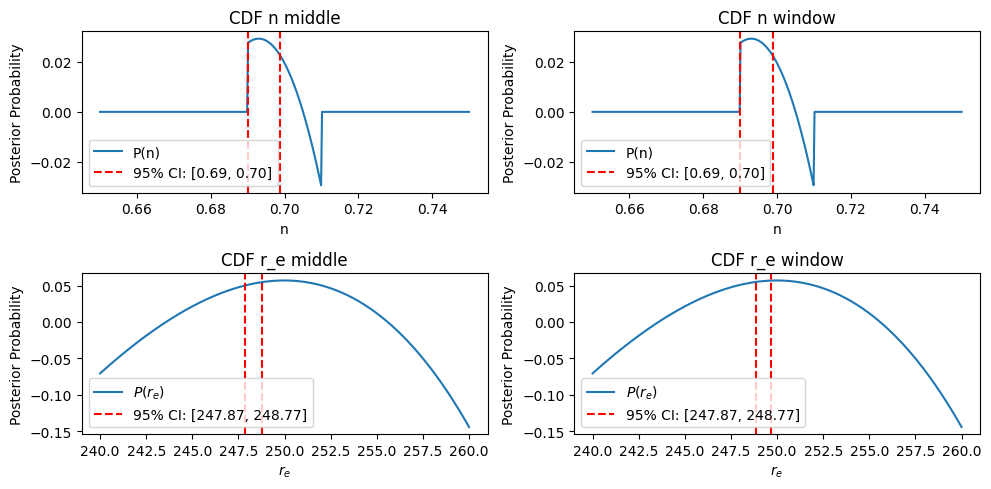

In [308]:
plt.figure(figsize=(10, 5))

# Marginalized n
plt.subplot(2, 2, 1)
plt.plot(n_space, n_mag, label='P(n)')
plt.title("CDF n middle")
plt.axvline(n_lower, color='r', linestyle='--', label=f"95% CI: [{n_lower:.2f}, {n_upper:.2f}]")
plt.axvline(n_upper, color='r', linestyle='--')
plt.xlabel("n")
plt.ylabel("Posterior Probability")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(n_space, n_mag, label='P(n)')
plt.title("CDF n window")
plt.axvline(n_min_interval[0], color='r', linestyle='--', label=f"95% CI: [{n_lower:.2f}, {n_upper:.2f}]")
plt.axvline(n_min_interval[1], color='r', linestyle='--')
plt.xlabel("n")
plt.ylabel("Posterior Probability")
plt.legend()

# Marginalized r_e
plt.subplot(2, 2, 3)
plt.title("CDF r_e middle")
plt.plot(r_e_space, r_e_mag, label=r'$P(r_e)$')
plt.axvline(r_e_lower, color='r', linestyle='--', label=f"95% CI: [{r_e_lower:.2f}, {r_e_upper:.2f}]")
plt.axvline(r_e_upper, color='r', linestyle='--')
plt.xlabel(r"$r_e$")
plt.ylabel("Posterior Probability")
plt.legend()

plt.subplot(2, 2, 4)
plt.title("CDF r_e window")
plt.plot(r_e_space, r_e_mag, label=r'$P(r_e)$')
plt.axvline(r_e_min_interval[0], color='r', linestyle='--', label=f"95% CI: [{r_e_lower:.2f}, {r_e_upper:.2f}]")
plt.axvline(r_e_min_interval[1], color='r', linestyle='--')
plt.xlabel(r"$r_e$")
plt.ylabel("Posterior Probability")
plt.legend()

plt.tight_layout()
plt.show()  

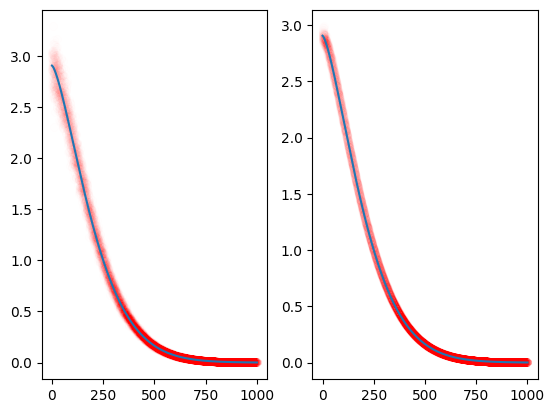

In [320]:
fractional_uncertainty = 0.01
sim_r_better, sim_r_uncertainty_better = sim_data(r_range, true_r_e, true_n, fractional_uncertainty)


plt.figure()
plt.subplot(1,2,1)
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n))
plt.scatter(r_range, sim_r, alpha=0.005, c="red")

plt.subplot(1,2,2)
plt.plot(r_range, sersic_profile(r_range, true_r_e, true_n))
plt.scatter(r_range, sim_r_better, alpha=0.005, c="red")
plt.show()


In [321]:
posterior_grid_better = np.zeros((len(r_e_space),len(n_space)))

for i in tqdm(range(len(n_space))):
    for j in range(len(r_e_space)):
        prior = flat_prior(r_e_space[j], n_space[i] )
        
        # Compute likelihood for this position (using the simulated data)
        model_param = r_range, n_space[i], r_e_space[j]
        likelihood_value_better = log_likelihood(r_range, sim_r_better, sim_r_uncertainty_better, r_e_space[j], n_space[i] )


        posterior_grid_better[i, j] = likelihood_value_better * prior * posterior_grid_old[i,j]



posterior_grid_better /= np.sum(posterior_grid_better)  # Normalize

#  best-fit parameters
max_idx = np.unravel_index(np.argmax(posterior_grid_better), posterior_grid_better.shape)
best_fit_n_better = n_space[max_idx[0]]
best_fit_r_e_better = r_e_space[max_idx[1]]

print(f"Best-fit n: {best_fit_n_better}")
print(f"Best-fit r_e: {best_fit_r_e_better}") 

100%|██████████| 400/400 [00:42<00:00,  9.44it/s]

Best-fit n: 0.75
Best-fit r_e: 250.97744360902254


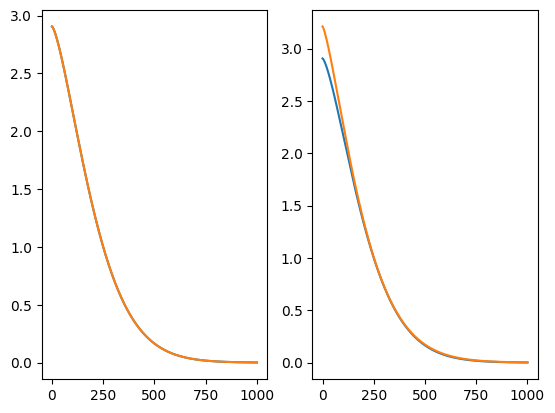

In [322]:
plt.figure()

plt.subplot(1,2,1)
plt.plot(r_range, sersic_profile(r_range, true_r_e,true_n))
plt.plot(r_range, sersic_profile(r_range, best_fit_r_e,best_fit_n))

plt.subplot(1,2,2)
plt.plot(r_range, sersic_profile(r_range, true_r_e,true_n))
plt.plot(r_range, sersic_profile(r_range, best_fit_r_e_better,best_fit_n_better))

plt.show()